## Import libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from numpy.linalg import inv
plt.rcParams["figure.figsize"] = (20,10)
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Least Squares Method for estimating trends (sklearn approach)

[[1]
 [2]
 [3]
 [4]]
[1.21 2.07 2.93 3.79]
0.35000000000000053
[0.86]


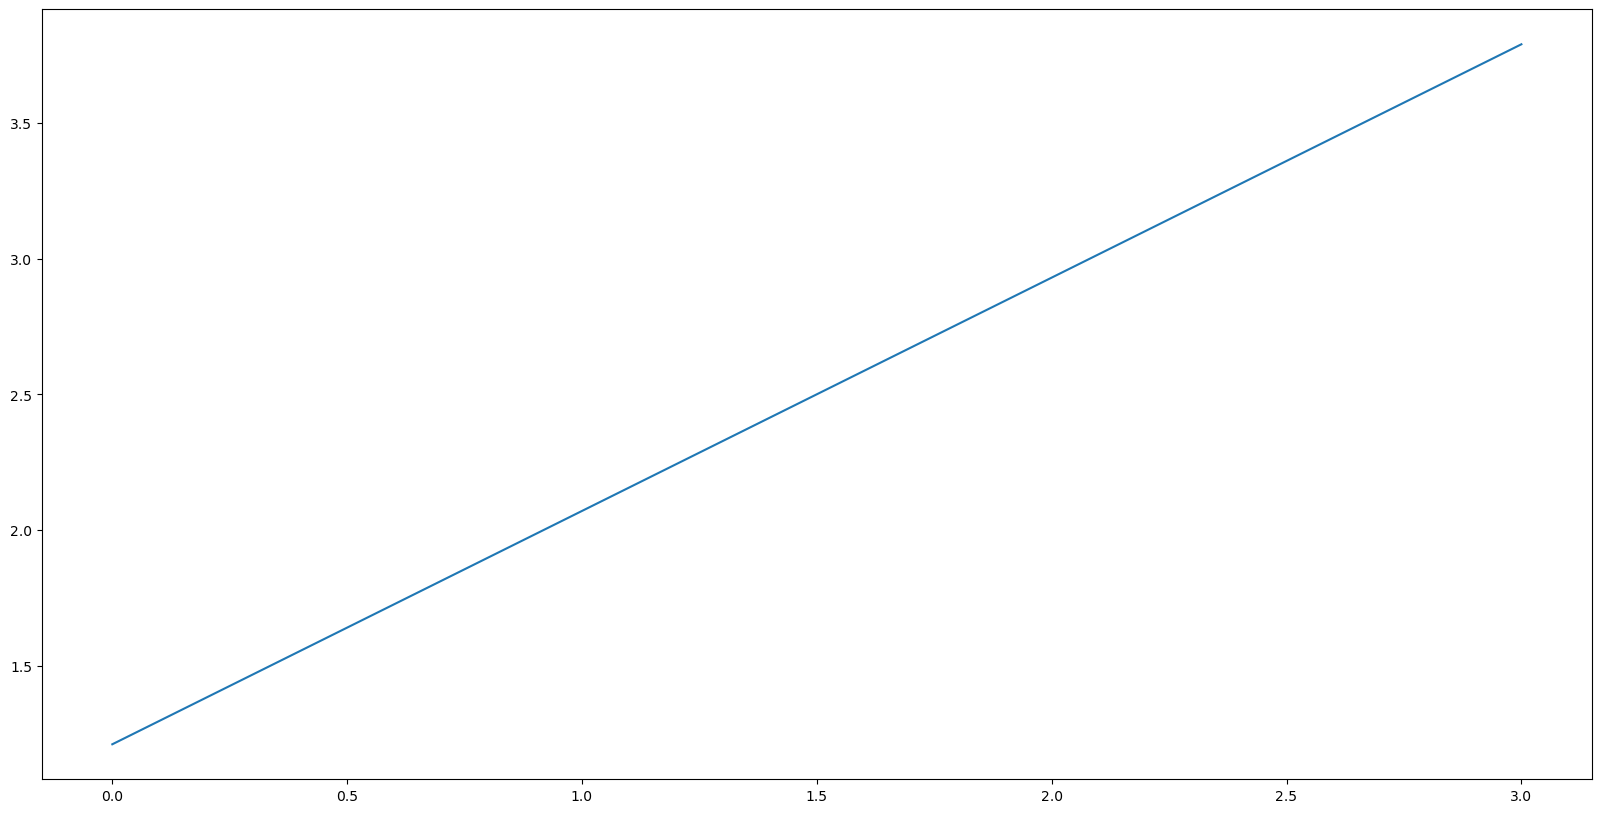

In [9]:
y = np.array([1.2, 2.1, 2.9, 3.8])
X = np.array([1, 2, 3, 4]).reshape(-1, 1)
print(X)
model = LinearRegression(fit_intercept=True)
model.fit(X, y)
T_hat = model.predict(X)
print(T_hat)
print(model.intercept_)
print(model.coef_)
plt.plot(T_hat)
plt.show()

## Least Squares Method for estimating trends (Math approach)

In [10]:
y_2 = np.array([1.2, 2.1, 2.9, 3.8])
X_2 = np.array([1, 2, 3, 4]).reshape(-1, 1)
T_hat_2 = X_2.dot(inv(X_2.T.dot(X_2))).dot(X_2.T).dot(y)
print(T_hat_2)

[0.97666667 1.95333333 2.93       3.90666667]


## Filtering Method for estimating trends

In [15]:
# Define the filtering function
def Filtering(Filter, r, series):
    filtered = []
    n = len(series)
    for t in range(r, n-r):
        filtered.append(round(Filter.dot(np.array(series[t-r: t+r+1]).T)))
    return filtered

# Construct the Spencer 15-point filter
Spencer_filter = 1/320 * np.array([-3, -6, -5, 3, 21, 46, 67, 74, 67, 46, 21, 3, -5, -6, -3])

# X_t = ct
c = 1
X_1 = c * np.arange(1, 1000)
filtered_X_1 = Filtering(Spencer_filter, 7, X_1)

# X_t = bt^2
b = 1
X_2 = b * np.arange(1, 1000)**2

# X_t = at^3
a = 1
X_3 = a * np.arange(1, 1000)**3
filtered_X_3 = Filtering(Spencer_filter, 7, X_3)
filtered_X_3

# X_t = dt^4
d = 1
X_4 = d * np.arange(1, 1000)**4
filtered_X_4 = Filtering(Spencer_filter, 7, X_4)


# X_t = et^5
e = 1
X_5 = e * np.arange(1, 1000)**5
filtered_X_5 = Filtering(Spencer_filter, 7, X_5)

# X_t = ft^6
f = 1
X_6 = f * np.arange(1, 1000)**6
filtered_X_6 = Filtering(Spencer_filter, 7, X_6)

## Differencing Method for estimating trends

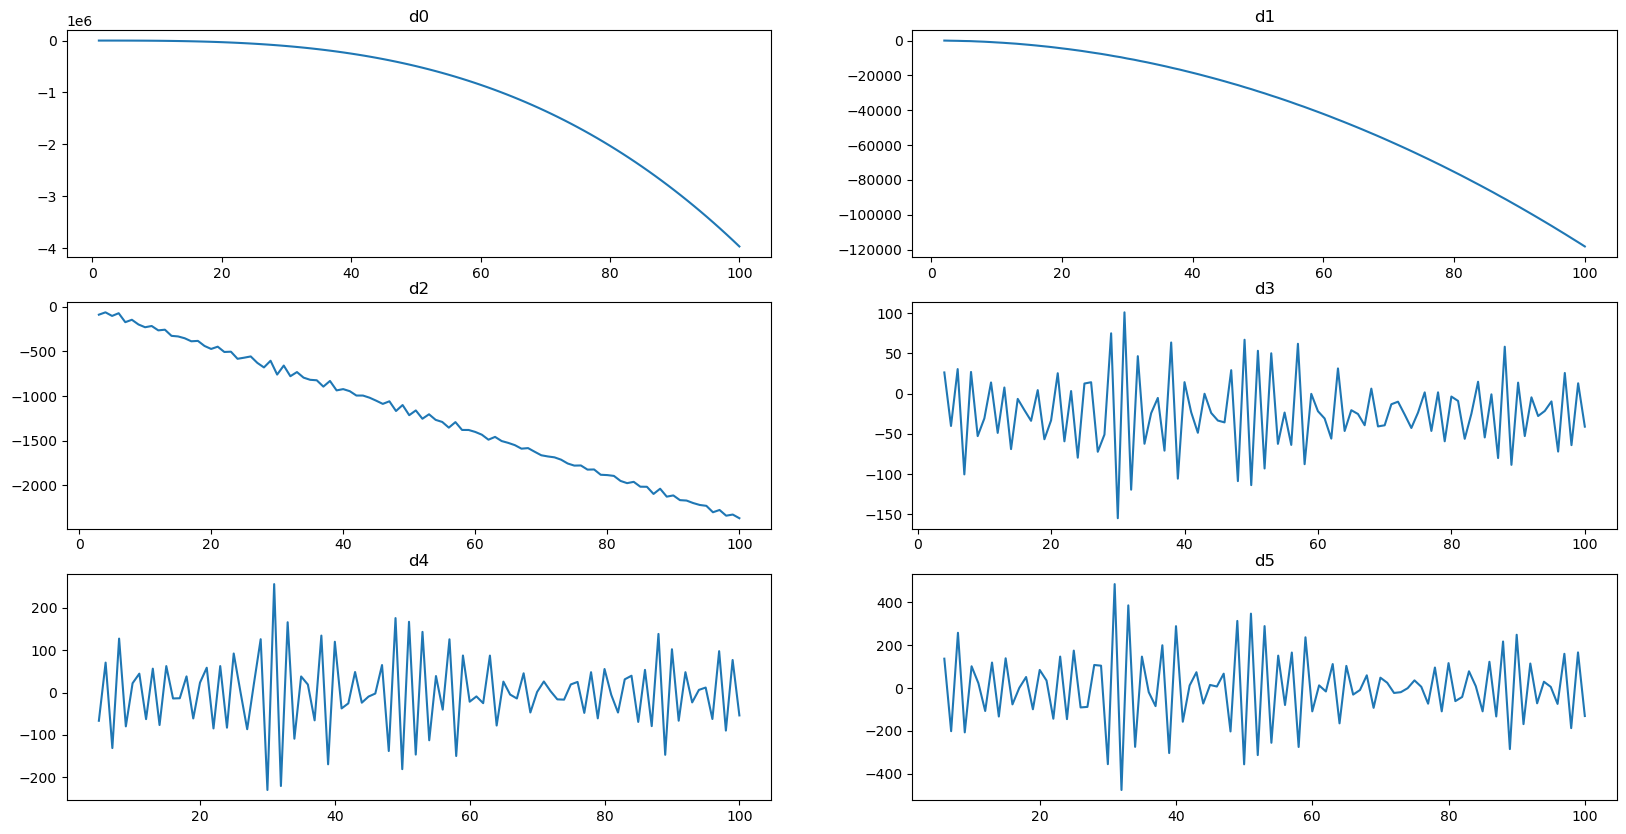

In [16]:
# Produce the noise
N_t = np.random.normal(0, 1, 100)

# Produce the array of t
t = np.arange(1, 101)

# Produce X
x = 5 - 2*t + 3*t**2 -4*t**3 + 10*N_t
X = pd.DataFrame({"d0":x}, index=t)
for i in range(1, 6):
    X[f"d{i}"] = X[f"d{i-1}"].diff()
fig, axs = plt.subplots(3, 2)
i = 0
j = 0
for col in X.columns:
    axs[i][j].plot(X[col])
    axs[i][j].set_title(col)
    if j == 1:
        j = 0
        i += 1
    else:
        j += 1
plt.show()

We can see the cubic trend can be elimated by 3 times of differencing

## Least Squares Method for estimating trends and seasonality

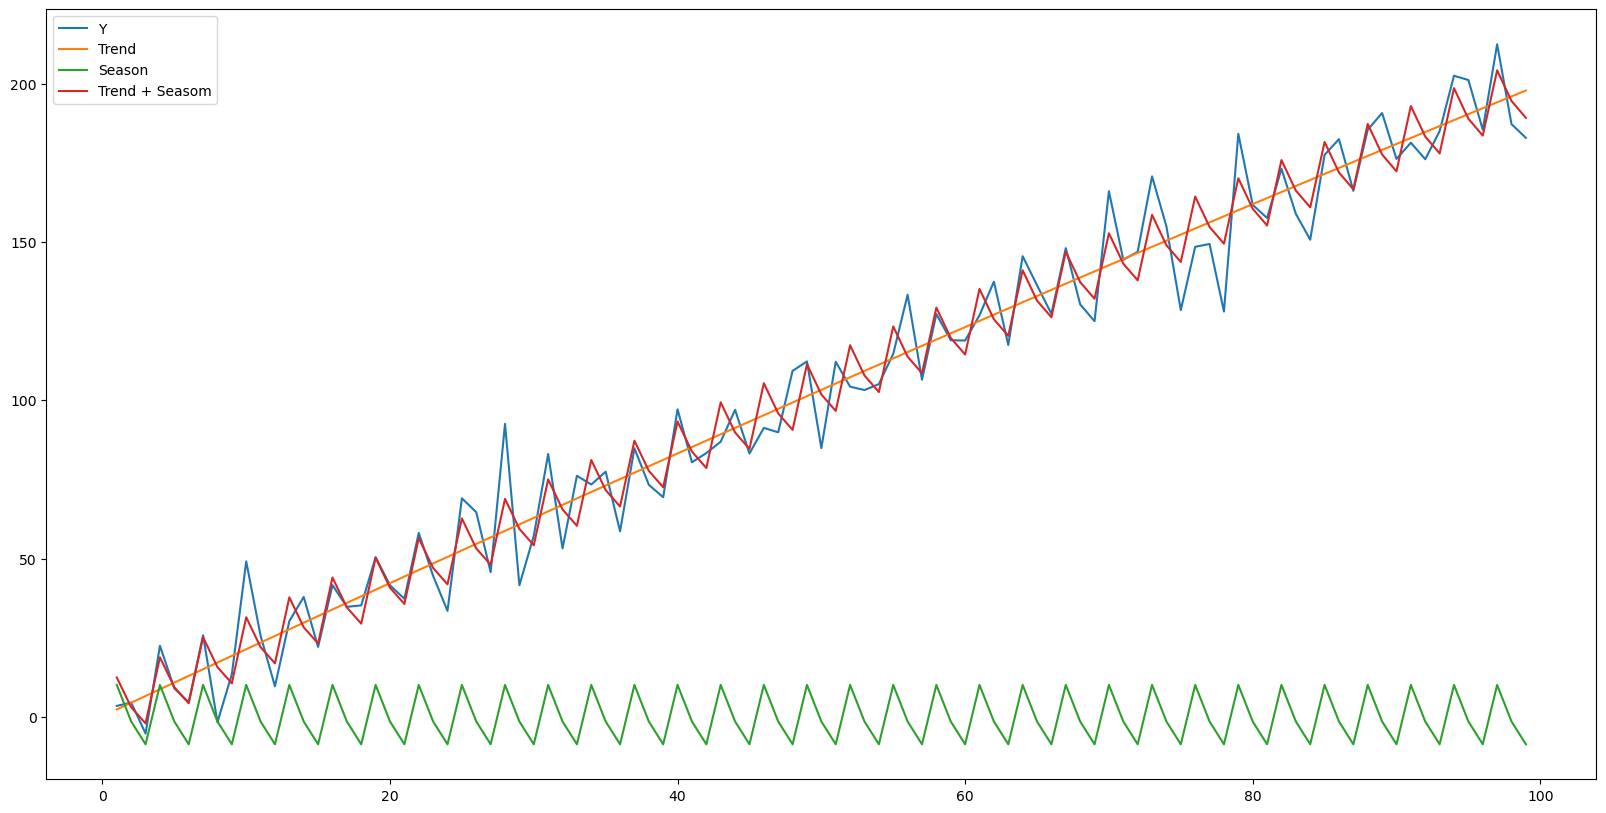

In [17]:
s1 = np.array([1, 0, 0] * 33)
s2 = np.array([0, 1, 0] * 33)
s3 = np.array([0, 0, 1] * 33)
N_t = np.random.normal(0, 1, 99)
t = np.arange(1, 100)
y = 3 + 2*t + 9*s1 - 9*s3 + 10*N_t
X = pd.DataFrame({"s1": s1, "s2": s2, "s3": s3, "t": t, "t^2": t**2}, index=t)
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
a_bar = model.coef_[:3].mean()
Trend = a_bar + np.array(X.iloc[:, 3:]).dot(model.coef_[3:].T)
Season = np.array(X.iloc[:, :3]).dot(model.coef_[:3].T) - a_bar
Y = pd.DataFrame({"Y": y, "Trend": Trend, "Season": Season, "Trend + Seasom": Trend + Season}, index=t)
Y.plot()
plt.show()

## Filtering Method for estimating trends and seasonality

In [18]:
# Defing the moving average filter
def MA_filter(q, d, T):
    T_hat = []
    t = len(T)
    if d == 2*q + 1:
        for i in range(q, t-q):
            T_hat.append(round(np.mean(T[i-q: i+q+1]), 3))
    else:
        for i in range(q, t-q):
            temp = 0
            temp += 1/2 * (T[i-q] + T[i+q])
            temp += np.sum(T[i-q+1: i+q])
            T_hat.append(round(temp/(2*q+1), 3))
    return T_hat

# Define the seasonality estimator
def Season_estimator(q, d, T, S):
    t = len(T)
    T_hat = MA_filter(q, d, T)
    D_t = np.array(T[q: t-q]) - np.array(T_hat)
    D_bar = np.mean(D_t)
    S = S[q: t-q]
    S_i = {}
    for s in S:
        if s not in S_i.keys():
            S_i[s] = [0, 0]
        else:
            pass
    for i in range(len(D_t)):
        S_i[S[i]][0] += D_t[i] - D_bar
        S_i[S[i]][1] += 1
    S_hat = []
    for s in S_i.keys():
        S_hat.append(S_i[s][0]/ S_i[s][1])
    return S_hat

In [19]:
T = [2.1, 3.9, 0.5, 2.8, 6.1, 8.2, 4.5, 6.9, 9.3, 11.9, 9.4]
S = [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3]
T_hat = MA_filter(2, 4, T)
S_hat = (Season_estimator(2, 4, T, S)*2 + Season_estimator(2, 4, T, S)[:3])
X_hat = np.array(MA_filter(2, 4, T)) + np.array(S_hat[2: -2])

In [20]:
X = pd.DataFrame({"X": T}, index=np.arange(1, 12))
temp1 = pd.Series(T_hat, name="T_hat", index=np.arange(1, 8))
temp2 = pd.Series(S_hat, name="S_hat", index=np.arange(1, 12))
temp3 = pd.Series(X_hat, name="X_hat", index=np.arange(1, 8))
X = pd.concat([X, temp1, temp2, temp3], axis=1)
X["T_hat"] = X["T_hat"].shift(2)
X["X_hat"] = X["X_hat"].shift(2)

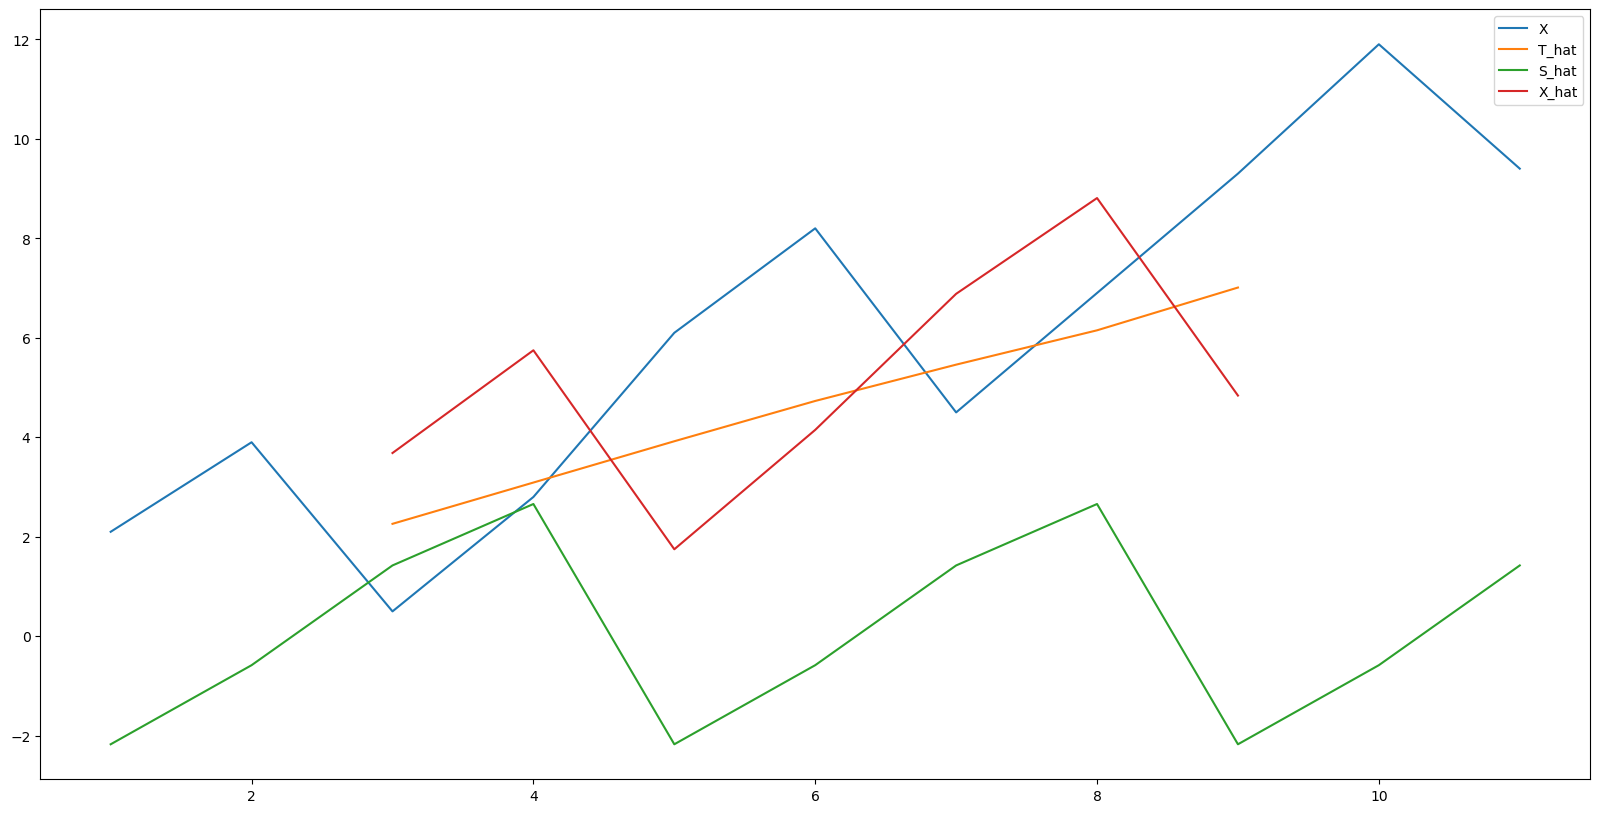

In [21]:
X.plot()
plt.show()

## Seasonal Differencing

In [22]:
def Seasonal_Differencing(d, T):
    T_hat = T - T.shift(d)
    return T_hat

In [23]:
T = [2.1, 3.0, 0.5, 2.8, 6.1, 8.2, 4.5, 6.9, 9.3, 11.9, 9.4]
series = pd.Series(T, index=np.arange(1, 12))
T_hat = Seasonal_Differencing(4, series)

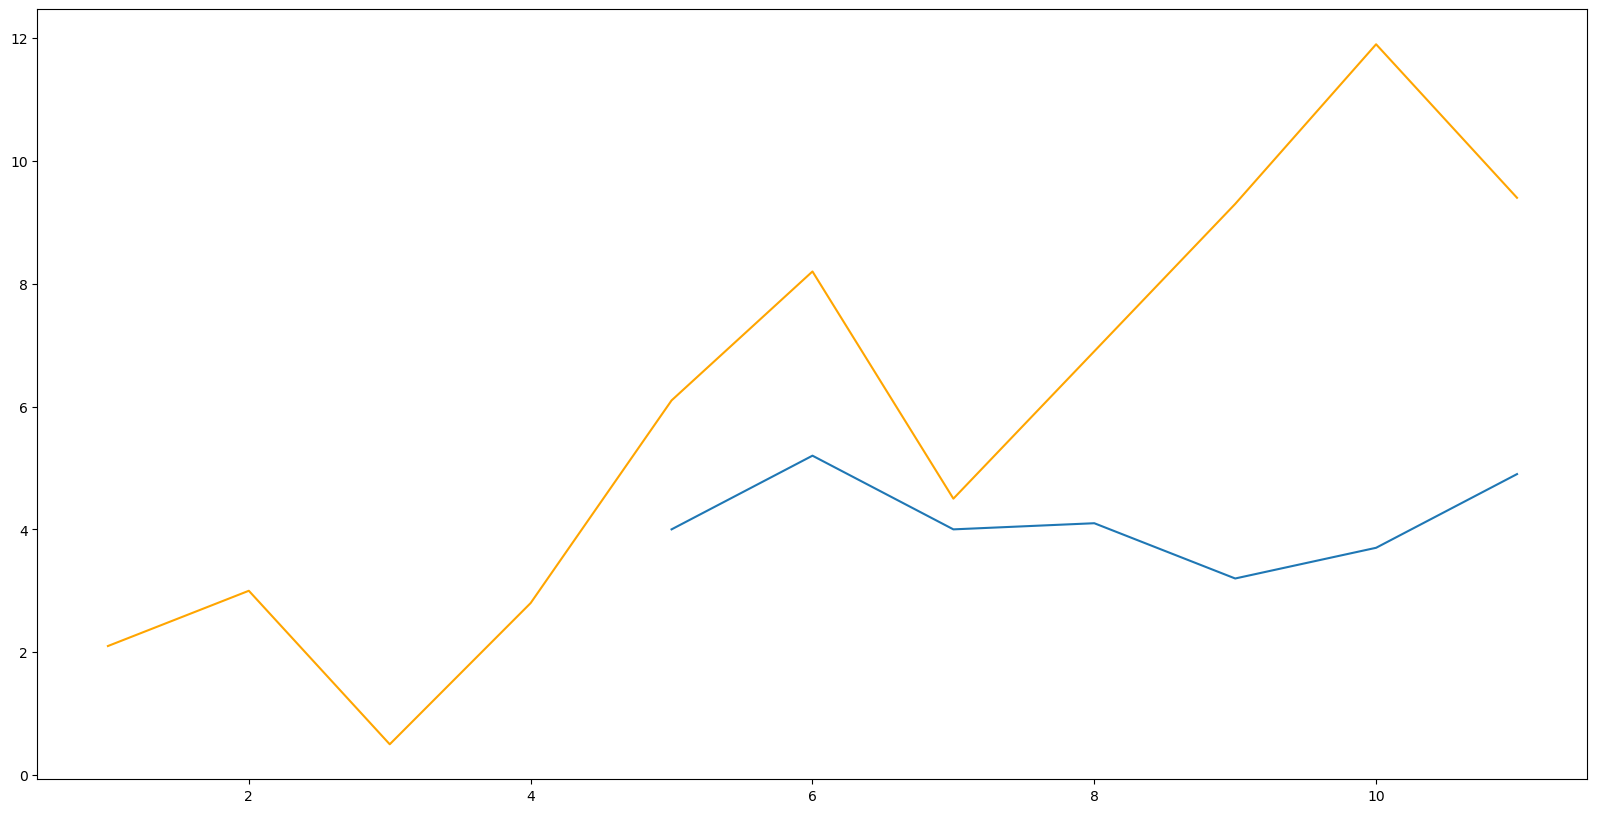

In [24]:
plt.plot(T_hat)
plt.plot(series, c="orange")
plt.show()